

    Implement advanced Transformer models using Keras.

    Apply Transformers to real-world sequential data tasks.

    Build, train, and evaluate Transformer models.


**Step 1 : Import Necessary libraries**

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import requests

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

In [17]:
# Setup the environment to generate synthetic stock price data

np.random.seed(42)
data_length = 2000  # Adjust data length as needed
trend = np.linspace(100, 200, data_length)
noise = np.random.normal(0, 2, data_length)
synthetic_data = trend + noise

# Create a DataFrame and save as 'stock_prices.csv'
data = pd.DataFrame(synthetic_data, columns=['Close'])
data.to_csv('stock_prices.csv', index=False)
print("Synthetic stock_prices.csv created and loaded.")

Synthetic stock_prices.csv created and loaded.


In [18]:
# Load the dataset
data = pd.read_csv('stock_prices.csv')
data = data[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Prepare the data for training
def create_dataset(data, time_step=1):
    X, Y = [], []

    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X, Y = create_dataset(data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (1899, 100, 1)
Shape of Y: (1899,)


In the above code:

tensorflow is the main library for machine learning in Python.

stock_prices.csv is the data set that is loaded.

MinMaxScaler method is used to normalize the data.

create_dataset method is used to prepare the data for training.


**Step 2 : Implement Multi-Head Self Attention**

In [19]:
class MultiHeadSelfAttention(Layer):

    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)


    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        attention, _ = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output



In the above code:

    The MultiHeadSelfAttention layer implements the multi-head self-attention mechanism, which allows the model to focus on different parts of the input sequence simultaneously.

    The attention parameter computes the attention scores and weighted sum of the values.

    The split_heads parameter splits the input into multiple heads for parallel attention computation.

    The call method applies the self-attention mechanism and combines the heads.



**Step 3 : Implement Transformer block**

In [20]:
class TransformerBlock(Layer):

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)


    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In the above code:

    The TransformerBlock layer combines multi-head self-attention with a feed-forward neural network and normalization layers.

    Dropout is used to prevent overfitting.

    The call method applies the self-attention, followed by the feedforward network with residual connections and layer normalization.



**Step 4: Implement ENcoder Layer**

In [21]:
class EncoderLayer(Layer):

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)



    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)



In the above code:

    The EncoderLayer is similar to the TransformerBlock but is a reusable layer in the Transformer architecture.

    It consists of a MultiHeadSelfAttention mechanism followed by a feedforward neural network.

    Both sub-layers have residual connections around them, and layer normalization is applied to the output of each sub-layer.

    The call method applies the self-attention, followed by the feedforward network, with residual connections and layer normalization.



**Step 5 : Implement Tranformer Encoder**

In [22]:
class MultiHeadSelfAttention(Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)


    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights


    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])


    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        attention, _ = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)


    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TransformerEncoder(Layer):
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
        self.dropout = Dropout(rate)

    def call(self, inputs, training=False):
        x = inputs
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training)
        return x

# Example usage
embed_dim = 128
num_heads = 8
ff_dim = 512
num_layers = 4

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim)
inputs = tf.random.uniform((1, 100, embed_dim))
outputs = transformer_encoder(inputs, training=False)  # Use keyword argument for 'training'
print(outputs.shape)  # Should print (1, 100, 128)

(1, 100, 128)


In the above code:

The TransformerEncoder is composed of multiple TransformerBlock layers, implementing the encoding part of the Transformer architecture.


**Step 6 : Build and Compile the Transformer Model**

In [23]:
# Define the necessary parameters

embed_dim = 128
num_heads = 8
ff_dim = 512
num_layers = 4

# Define the Transformer Encoder
transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim)

# Build the model
input_shape = (X.shape[1], X.shape[2])
inputs = tf.keras.Input(shape=input_shape)

# Project the inputs to the embed_dim
x = tf.keras.layers.Dense(embed_dim)(inputs)
encoder_outputs = transformer_encoder(x)
flatten = tf.keras.layers.Flatten()(encoder_outputs)
outputs = tf.keras.layers.Dense(1)(flatten)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Summary of the model
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 100, 1)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_122 (Dense)                    │ (None, 100, 128)            │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_4                │ (None, 100, 128)            │         793,088 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_123 (Dense)                    │ (None, 1)                   │          12,801 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 806,145 (3.08 MB)

 Trainable params: 806,145 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

**Step 7 : Train the Transformer model**

In [24]:
# Train the model
model.fit(X, Y, epochs=20, batch_size=32)


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 61s 756ms/step - loss: 12.4301
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 40s 667ms/step - loss: 0.1982
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 692ms/step - loss: 0.1810
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 685ms/step - loss: 0.1266
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 43s 713ms/step - loss: 0.1412
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 683ms/step - loss: 0.1229
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 675ms/step - loss: 0.1470
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 687ms/step - loss: 0.1028
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 701ms/step - loss: 0.1109
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 676ms/step - loss: 0.1749
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 676ms/step - loss: 0.1011
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 681ms/step - loss: 0.0918
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s 676ms/step - loss: 0.0991
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 682ms/step - loss: 0.0718
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 81s

**Step 8: Evaluate and Make Predictions**

Evaluate the model's performance and make predictions on the dataset.

60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 253ms/step


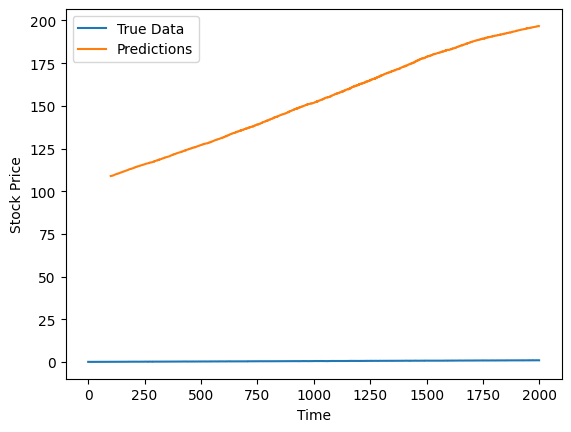

In [25]:
# Make predictions
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)


# Plot the predictions
import matplotlib.pyplot as plt

plt.plot(data, label='True Data')
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In the above code:

    The model's predictions are transformed back to the original scale using the inverse transform of the scaler.

    The true data and predictions are plotted to visualize the model's performance.

